In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [20]:
def points_for_boundary(X, clf):
    x_min, x_max = X.iloc[:, 0].agg(['min', 'max'])
    y_min, y_max = X.iloc[:, 1].agg(['min', 'max'])
    xs = np.linspace(x_min, x_max, 100)
    ys = np.linspace(y_min, y_max, 100)
    points = pd.DataFrame({
        'xs': np.tile(xs, len(ys)),
        'ys': np.repeat(ys, len(xs)),
    })
    return points.assign(pred=clf.predict(points))

In [33]:
def decision_boundary(X, y, clf):
    pred = points_for_boundary(X, clf)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    sns.scatterplot('xs', 'ys', hue='pred', data=pred, alpha=0.2, s=40,
                    legend=False)
    sns.scatterplot(X.iloc[:, 0], X.iloc[:, 1], hue=y,
                    s=60, legend=False)
    
    plt.subplot(122)
    sns.scatterplot('xs', 'ys', hue='pred', data=pred, s=40, legend=False)

## Bagging

In [129]:
from sklearn.datasets import make_moons, make_circles

X, y = make_circles(1000, noise=0.1, random_state=42)
data = pd.DataFrame(X, columns=['x1', 'x2']).assign(y=y)
data

,x1,x2,y
0,0.71,0.28,1
1,-0.68,0.21,1
2,-0.87,0.34,1
...,...,...,...
997,-0.11,-0.87,1
998,0.64,-0.86,0
999,0.27,0.98,0


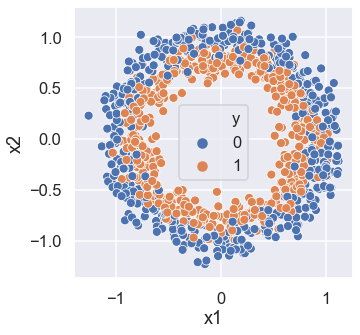

In [161]:
plt.figure(figsize=(5, 5))
sns.scatterplot('x1', 'x2', hue='y', data=data)

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data[['x1', 'x2']], data['y'], test_size=0.2, random_state=42)
X_train

,x1,x2
29,0.73,-0.40
535,0.53,-0.73
695,-1.06,-0.06
...,...,...
860,-0.04,-1.10
435,1.06,0.21
102,0.56,-0.56


In [138]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

1.0

In [139]:
# Much worse!
tree.score(X_test, y_test)

0.685

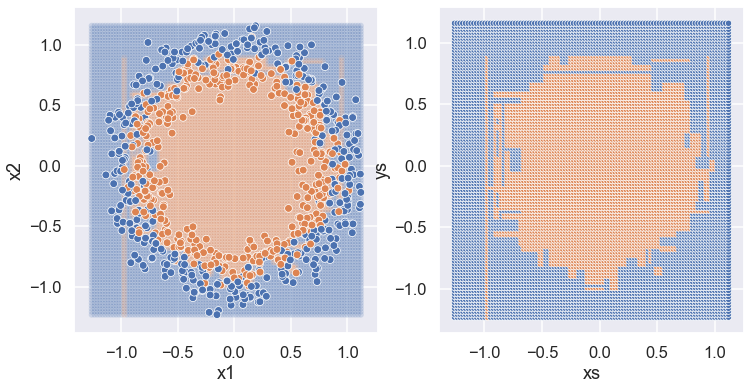

In [140]:
decision_boundary(X_train, y_train, tree)

In [146]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'),
                                n_estimators=100)
bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_train, y_train)

1.0

In [151]:
bagging_clf.score(X_test, y_test)

0.725

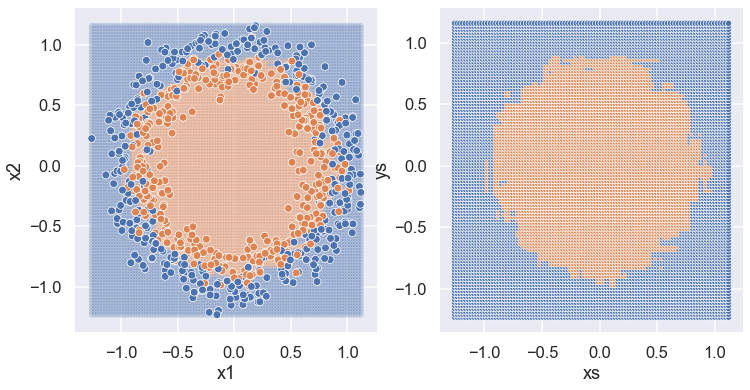

In [150]:
decision_boundary(X_train, y_train, bagging_clf)

## Random Forests

In [158]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

1.0

In [159]:
rf.score(X_test, y_test)

0.74

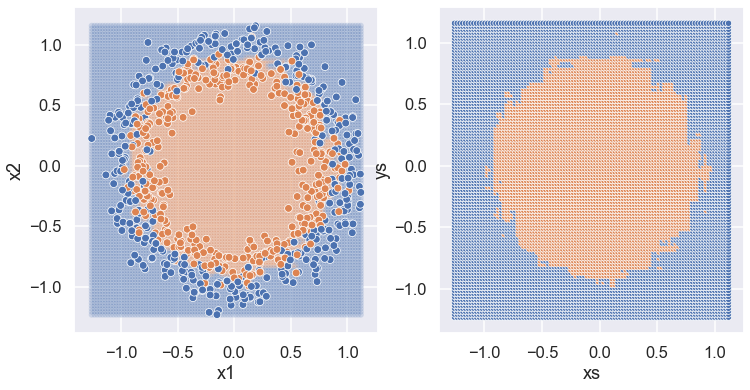

In [160]:
decision_boundary(X_train, y_train, rf)

Check how RF performs on spam/ham:

In [162]:
spam = pd.read_csv('spam-train.csv')
train, valid = train_test_split(spam, test_size=0.15, random_state=42)
train

,id,subject,email,spam
7064,7064,"Subject: Be First...It""s Your Turn...Don't Mis...",Finally: After 15 Years of Research and Develo...,1
5918,5918,Subject: Re: Entrepreneurs\n,"On Thu, Aug 22, 2002 at 10:58:34PM +0200, Robe...",0
6459,6459,Subject: Play by Play: Effective Memory Manage...,"URL: http://www.newsisfree.com/click/-0,861367...",0
...,...,...,...,...
5390,5390,Subject: Facts about sex.\n,\n Forwarded-by: Flower\n \n Did you know that...,0
860,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"On Tue, Oct 08, 2002 at 04:36:13PM +0200, Matt...",0
7270,7270,Subject: Re: Internet radio - example from a c...,Chris Haun wrote:\n > \n > We would need someo...,0


In [237]:
# I just picked 500 words at random from all the words in the emails
words = pd.read_csv('sam-words.csv', header=None).iloc[:, 0]
words

0           total
1           catch
2      introduced
          ...    
497      discount
498         sales
499     clickthru
Name: 0, Length: 500, dtype: object

In [218]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer(min_df=0.01, stop_words='english')
counter.fit(train['email'])
len(counter.get_feature_names())

2348

In [219]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer(vocabulary=words)
counter.fit(train['email'])
len(counter.get_feature_names())

500

In [221]:
X_train = pd.DataFrame(counter.transform(train['email']).todense(),
                       columns=counter.get_feature_names())
X_train

,total,catch,introduced,campaign,...,feet,discount,sales,clickthru
0,0,0,0,0,...,0,0,0,0
1,0,0,0,0,...,0,0,0,0
2,0,0,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
7092,0,0,0,0,...,0,0,0,0
7093,0,0,0,0,...,0,0,0,0
7094,0,0,0,0,...,0,0,0,0


In [222]:
y_train = train['spam']
X_valid = pd.DataFrame(counter.transform(valid['email']).todense(),
                       columns=counter.get_feature_names())
y_valid = valid['spam']

In [225]:
%%time

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

CPU times: user 341 ms, sys: 21.2 ms, total: 362 ms
Wall time: 372 ms


In [232]:
from sklearn.metrics import confusion_matrix, roc_auc_score

confusion_matrix(y_valid, log_reg.predict(X_valid))

array([[905,  14],
       [ 44, 290]])

In [234]:
roc_auc_score(y_valid, log_reg.predict_proba(X_valid)[:, 1])

0.9752089944159558

In [227]:
%%time

clf = RandomForestClassifier(n_estimators=100, n_jobs=4)
clf.fit(X_train, y_train)

CPU times: user 7.17 s, sys: 104 ms, total: 7.27 s
Wall time: 2.66 s


In [228]:
clf.score(X_train, y_train)

0.9987315010570824

In [229]:
clf.score(X_valid, y_valid)

0.9840383080606544

In [235]:
confusion_matrix(y_valid, clf.predict(X_valid))

array([[915,   4],
       [ 16, 318]])

In [236]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])

0.9954161318277481

## Runtime Considerations

In [245]:
%%timeit

n = 1_000_000

[i ** 2 for i in range(n)]

322 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [246]:
%%timeit

n = 2_000_000

[i ** 2 for i in range(n)]

661 ms ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


numpy makes things run much faster but doesn't change how the runtime grows!

In [247]:
%%timeit

n = 1_000_000

np.arange(n) ** 2

3.26 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [248]:
%%timeit

n = 2_000_000

np.arange(n) ** 2

8.8 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
